In [ ]:
# If GCS data mount is not populated perform following steps in vm: 
"""
# Stop/Unmount any previous attempts 
# Try to unmount the directory in case a previous attempt left it mounted
# If this fails, it's fine, it just means it wasn't mounted.
fusermount -u ~/gcs_pdbbind_mount

# If /gcs_pdbbind_mount not visible in file system create dir for local mount point:
mkdir ~/gcs_pdbbind_mount

# Replace BUCKET_NAME and DIRECTORY_PATH
BUCKET_NAME="cs224w-2025-mae-gnn-bucket"
DIRECTORY_PATH="data/GEMS_pytorch_datasets" 

gcsfuse --only-dir "$DIRECTORY_PATH" -o allow_other --implicit-dirs "$BUCKET_NAME" ~/gcs_pdbbind_mount

#Verify the Mount:
ls -l ~/gcs_pdbbind_mount

# You should see your .pt files listed here, proving the mount worked.


In [1]:
!pip install torch_geometric pandas matplotlib
!pip install "numpy<2"

In [2]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print("torch version:", torch.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

torch version: 1.13.1+cu117
numpy version: 1.26.4
pandas version: 2.3.3


In [25]:
# CONSTANTS

# Need to download Dataset.py from GEMS directory locally onto vm first
# git clone http://github.com/camlab-ethz/GEMS.git
# Define root path of cloned GEMS repo
GEMS_REPO_ROOT = os.path.expanduser('~/GEMS')

# Define the directory path where pre-processed .pt dataset files are located
DATA_DIR = os.path.join(os.path.expanduser('~'), 'gcs_pdbbind_mount')

# List of dataset files to analyze
DATASET_FILES = [
    # '00AEPL_casf2013.pt',
    # '00AEPL_casf2013_indep.pt',
    '00AEPL_casf2016.pt',
    '00AEPL_casf2016_indep.pt',
    '00AEPL_train_cleansplit.pt',
    # '00AEPL_train_pdbbind.pt'
]

ALL_ATOMS = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'metal', 'halogen']

ATOM_HYBRIDIZATION_TYPES = ["HybridizationType.S", "HybridizationType.SP", "HybridizationType.SP2", "HybridizationType.SP2D", "HybridizationType.SP3", "HybridizationType.SP3D", "HybridizationType.SP3D2", "HybridizationType.UNSPECIFIED"]
TOTAL_NUM_H_S = ["Num_H.0", "Num_H.1", "Num_H.2", "Num_H.3", "Num_H.4"]
DEGREES = ['Degree.0', 'Degree.1', 'Degree.2', 'Degree.3', 'Degree.4', 'Degree.5', 'Degree.6', 'Degree.7', 'Degree.8', 'Degree.OTHER']
CHIRALITIES = ['Chirality.CHI_UNSPECIFIED', 'Chirality.CHI_TETRAHEDRAL_CW', 'Chirality.CHI_TETRAHEDRAL_CCW', 'Chirality.OTHER']

AMINO_ACIDS = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU",
            "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]

LIGAND_FEATURE_MAP = ALL_ATOMS + ["IsInRing"] + ATOM_HYBRIDIZATION_TYPES + \
                    ["FORMAL_CHARGE", "IS_AROMATIC", "MASS/100", ] + TOTAL_NUM_H_S + \
                    DEGREES + CHIRALITIES
FULL_FEATURE_MAP = LIGAND_FEATURE_MAP + AMINO_ACIDS

EDGE_FEATURE_MAP = ["COVALENT_BOND", "SELF_LOOP", "NON-COVALENT_BOND", "EDGE_LENGTH/10", "EDGE_LENGTH/10", "EDGE_LENGTH/10", "EDGE_LENGTH/10" ] + \
                   ["BOND_TYPE_0", "BOND_TYPE_1.0", "BOND_TYPE_1.5", "BOND_TYPE_2.0", "BOND_TYPE_3.0"] + \
                   ["IS_CONJUGATED", "IS_IN_RING", "BOND_STEREO.NONE", "BOND_STEREO.ANY", "BOND_STEREO.E", "BOND_STEREO.Z", "BOND_STEREO.CIS", "BOND_STEREO.TRANS"]


In [7]:
# Dynamic Import of Custom Datasets Class
# Add the directory to Python's search path.
print(f"Attempting to load custom Dataset class...")

try:
  # Add GEMS root to sys.path
  if GEMS_REPO_ROOT not in sys.path:
    sys.path.append(GEMS_REPO_ROOT)
    print(f"Added {GEMS_REPO_ROOT} to sys.path")

    # Import custom Dataset class from the cloned repo
    from Dataset import Dataset as GEMS_Dataset
    print("Successfully imported custom Dataset class")

    # Import the necessarty PyG components
    from torch_geometric.data import Data #, Dataset

except ImportError as e:
    raise RuntimeError(f"FATAL ERROR importing GEMS Dataset class: {e}")


Attempting to load custom Dataset class...
Added /home/jupyter/GEMS to sys.path
Successfully imported custom Dataset class


In [8]:
def extract_metrics(data_list):
   """Iterates through list of GEMS datasets and extracts metrics."""
   metrics = []

    num_features = data_list[0].x.size(1)
    for i, data in enumerate(data_list):
        # Affinity is the y label
        affinity = data.y.item()

        # ID (Assuming is stored in 'id' attribute)
        pdb_id = getattr(data, 'id', f'Complex_{i}')

        # Extract Graph Size Metrics
        # node features (x): shape is [num_atoms, num_features]
        num_nodes = data.x.size(0)

        # Edge index: shape is: [2, num_edges]
        num_edges = data.edge_index.size(1)
    
        [n_nodes, n_ligand_nodes, n_protein_nodes] = data.n_nodes.numpy()

        # Isolate ligand rows
        ligand_x = data.x[:n_ligand_nodes]
        
        # Slice the tensor to only get the atom on-hot columns
        ligand_heavy_atoms_oh = ligand_x[:, :len(ALL_ATOMS)]
        is_heavy_atom = (ligand_heavy_atoms_oh.any(dim=1)).float()
        heavy_atom_count = is_heavy_atom.sum().item()

        # Isolate protein rows
        protein_x = data.x[n_ligand_nodes:]
        
        # Slice the tensor to only get the amino acid one-hot columns (last 20 cols)
        protein_aa_oh = protein_x[:, num_features - len(AMINO_ACIDS):]
        protein_aa_counts = protein_aa_oh.sum(dim=0)
        
        # Feature counts
        feature_counts_tensor = torch.sum(data.x, dim=0)

        # Append the aggregated features to the list
        record = {
            'PDB_ID': pdb_id,
            'Affinity_pKi_pKd': affinity,
            'Num_Nodes': num_nodes,
            'Num_Ligand_Atoms': n_ligand_nodes,
            'Num_Ligand_Heavy_Atoms': heavy_atom_count,
            'Num_Protein_Amino_Acid_Nodes': n_protein_nodes,
            'Num_Interactions': num_edges,
            'Density': num_edges / num_nodes,
        }

        # Add feature counts dynamically
        for j, feature_name in enumerate(FULL_FEATURE_MAP):
        record[f'Feature_{feature_name}'] = feature_counts_tensor[j].item()

        metrics.append(record)

    return pd.DataFrame(metrics)

In [9]:
def run_data_analysis(df, dataset_name):
    """Performs data analysis on dataframe and produces visualizations"""

    print(f"Analyzing {dataset_name} dataset (N={len(df)})...")

    # Affinity Distribution
    print("\n[1] Affinity Distribution")
    print(df['Affinity_pKi_pKd'].describe())

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    df['Affinity_pKi_pKd'].hist(bins=50)
    plt.title(f'{dataset_name}: Affinity Distribution')
    plt.xlabel('Binding Affinity (pKi/pKd)')
    plt.ylabel('Frequency')

    # Graph Size Metrics
    print("\n[2] Graph Size Metrics")
    print(df[['Num_Nodes', 'Num_Interactions', 'Density']].describe())

    df[['Num_Nodes', 'Num_Interactions', 'Density']].hist(bins=50)

    sns.histplot(
        data=df['Num_Ligand_Heavy_Atoms'],
        x='Ligand Heavy Atom Count',
        kde=True,
        bins=25,
        color='#1f77b4',
        edgecolor='black',
        linewidth=0.8
    )
    heavy_atom_mean_count = df['Num_Ligand_Heavy_Atoms'].mean()
    plt.title(f'Distribution of Ligand Heavy Atom Counts')
    plt.xlabel('Number of Heavy Atoms per Ligand' fontsize=12)
    plt.ylabel('Frequency (Number of Ligands)', fontsize=12)
    plt.axvline(heavy_atom_mean_count, color='red', linestyle='--', label=f'Mean: {mean_count:.2f} Atoms')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    
    print("Summary Statistics for Ligand Heavy Atom Counts:")
    print(df['Num_Ligand_Heavy_Atoms'].describe().transpose())
    
    plt.tight_layout()
    plt.show()

    # Protein Diversity
    # Use PDB_ID count to determine protein complexes
    unique_complexes = df['PDB_ID'].nunique()
    print(f"\n[3] Protein Diversity: {unique_complexes} unique proteins")
    print(f"Redundancy Ratio (Total N / Unique N): {len(df) / unique_complexes:.2f}")

    # Node Feature Frequency
    # Summing up total count for the top 5 most frequent features
    feature_cols = [col for col in df.columns if col.startswith('Feature_')]
    top_5_features = df[feature_cols].sum().nlargest(5).index.tolist()

    # Edge Feature Frequency
    # TODO
    
    print("\n[4] Node Feature Frequency")
    print(f"Top 5 Features: {', '.join(top_5_features)}")
    print("--------------------------\n")
    # TODO: map features to actual atom types


In [10]:

def run_test(data_list):
    num_features = data_list[0].x.size(1)
    print("Num features:", num_features)
    data = data_list[0]
    
    # Affinity is the y label
    affinity = data.y.item()
    print("affinity:", affinity)
    
    # ID (Assuming is stored in 'id' attribute)
    pdb_id = getattr(data, 'id', f'Complex_{i}')
    print("Pdb id:", pdb_id)
    
    # Extract Graph Size Metrics
    # node features (x): shape is [num_atoms, num_features]
    num_nodes = data.x.size(0)
    print("num nodes:", num_nodes)

    
    # Edge index: shape is: [2, num_edges]
    num_edges = data.edge_index.size(1)
    print("num_edges:", num_edges)

    # Atom feature counts
    feature_counts_tensor = torch.sum(data.x, dim=0)
    


In [45]:
data = data_list[0]
data.n_nodes # represent
[n_nodes, n_ligand_nodes, n_protein_nodes] = data.n_nodes.numpy()

#data.n_nodes
ligand_x = data.x[:n_ligand_nodes]
ligand_heavy_atoms_oh = ligand_x[:, :len(ALL_ATOMS)]
is_heavy_atom = (ligand_heavy_atoms_oh.any(dim=1)).float()
heavy_atom_count = is_heavy_atom.sum().item()

ligand_x.shape[0]
#ligand_x
#df = extract_metrics(data_list)
#x_df = pd.DataFrame(data.x.numpy(), columns=FULL_FEATURE_MAP)
#print(x_df[AMINO_ACIDS])

# data.edge_attr[0]

39

In [27]:
def run_data_analysis_across_datasets(all_data_df):
    plt.figure(figsize=(8,5))
    sns.boxplot(
        x='Dataset',
        y='Affinity_pKi_pKd',
        data=all_data_df,
    )

    plt.title('Binding Affinity Distribution Across Datasets')
    plt.xlabel('Dataset Split')
    plt.ylabel('Binding Affinity ($pK_i$ or $pK_d$)')
    plt.grid(axis='y', linestyle='--')
    plt.show()


Loading 00AEPL_casf2016.pt [1/3]...
Example data object type: <class 'torch_geometric.data.data.Data'>
Loading 00AEPL_casf2016_indep.pt [2/3]...
Example data object type: <class 'torch_geometric.data.data.Data'>
Loading 00AEPL_train_cleansplit.pt [3/3]...
Example data object type: <class 'torch_geometric.data.data.Data'>


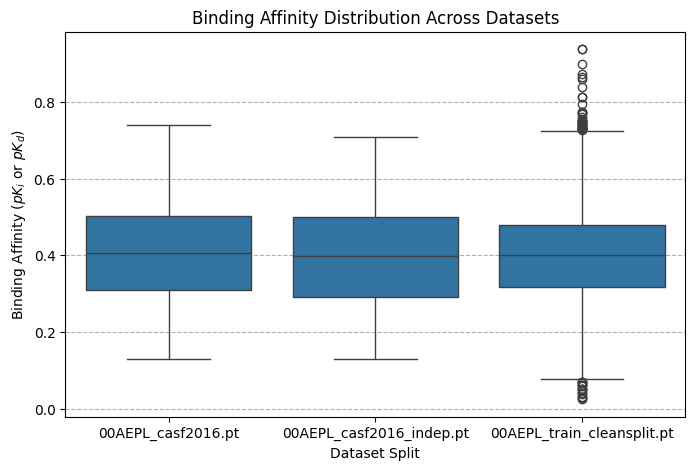

--------------| Data analysis completed! |------------


In [26]:
# Main loop
if not os.path.exists(DATA_DIR):
    raise RuntimeError(f"FATAL ERROR: Path {DATA_DIR} does not exist.")

all_data_df = pd.DataFrame({"Affinity_pKi_pKd": [], "Dataset": []})

for i, filename in enumerate(DATASET_FILES):
    data_filepath = os.path.join(DATA_DIR, filename)

    if not os.path.exists(data_filepath):
        print(f"WARNING: File not found: {data_filepath}. Skipping...")
        continue

    print(f"Loading {filename} [{i+1}/{len(DATASET_FILES)}]...")
    try:
        # Load data_list
        data_list = torch.load(data_filepath)
        print(f"Example data object type: {type(data_list[0])}")

        #run_test(data_list)
        # Run analysis
        df = extract_metrics(data_list)
        #run_data_analysis(df, filename)
        all_data_df = pd.concat([all_data_df, df[["Affinity_pKi_pKd"]].assign(Dataset=filename)])

    except Exception as e:
        print(f"\nFAILED PROCESSING {filename}: {e}")

print("--------------| Data analysis completed! |------------")

## Target Variable Analysis

In [ ]:
run_data_analysis_across_datasets(all_data_df)

## Binding Affinity Distribution Across Datasets
The median affinity across the datasets is similar, giving confidence that the average binding strength of the test sets is similar to the training set.  A difference would indicate potential bias.  

The circles outside of the whiskers indicates the presence of outliers in the training set, which means the model will have to learn from a wide range of values.

A follow up will be to validate the data points, that the outliers are not due to errors.